In [28]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns

In [6]:
os.chdir('/home/users/richras/Ge2Net_Repo')
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'
os.environ['WANDB_DIR']='/scratch/users/richras/Batch_jobs/wandb'
os.environ['IMAGE_PATH']='/scratch/groups/cdbustam/richras/images'

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/home/users/richras/Ge2Net_Repo')
from helper_funcs import load_path, save_file, vcf2npy, Params, load_model, get_recomb_rate, interpolate_genetic_pos,\
form_windows
from models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_D,\
Model_E, Model_F, Model_G, Model_H, Model_I, Model_L, BOCD
from models.distributions import Multivariate_Gaussian
from evaluation import eval_cp_batch

In [3]:
seed = 1233
np.random.seed(seed)

In [17]:
config={}
config['data.data_in'] = '/scratch/groups/cdbustam/richras/data_in'
config['data.data_out'] = '/scratch/groups/cdbustam/richras/data_out'
config['data.data_dir'] = '/scratch/groups/cdbustam/richras'
config['data.params_dir'] =  '/home/users/richras/Ge2Net_Repo/experiments/coordinates/exp_D7_dogs_chr22/' 
config['train.experiment_name'] = 'unsupervised_labels' 
config['train.experiment_id'] = 6
config['data.labels_dir'] = '/scratch/groups/cdbustam/richras/data_out/dogs/sm_expt1/unsupervised_labels/6'
config['model.working_dir'] = '/scratch/groups/cdbustam/richras/data_out/dogs/models_dir'
# config['data.vcf_dir'] = '/scratch/groups/cdbustam/richras/master_vcf_files/ref_final_beagle_phased_1kg_hgdp_sgdp_chr22.vcf.gz'
# config['data.genetic_map'] = '/scratch/groups/cdbustam/richras/reference_files/allchrs.b38.gmap'
config['model.pretrained_version'] = 'Model_D_7.1.1'
config['cuda'] = 'cuda:0'
config['geno_type'] ='dogs'
config['data.sample_map']='expt1'

json_path = os.path.join(config['data.params_dir'], 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.cuda = torch.cuda.is_available()
params.device = torch.device(config['cuda'] if params.cuda else 'cpu')

In [5]:
model_aux = AuxiliaryTask.AuxNetwork(params).to(params.device)
model_main = LSTM.BiRNN(params).to(params.device)
model_cp = BasicBlock.logits_Block(params).to(params.device)
model_sp = BasicBlock.Multi_Block(params).to(params.device)
model_residual = BasicBlock.Residual_Block(params).to(params.device)
model_path = osp.join(config['model.working_dir'], config['model.pretrained_version'], 'best.pt')
model_ls = [model_aux, model_main, model_cp, model_sp, model_residual]

model_ret = load_model(model_path, model_ls)
model = Model_D.model_D(*model_ret, params=params)

best val accuracy : accr(l1_loss=0.5356340396367602, mse_loss=1.0645197550292207, smoothl1_loss=tensor(0.3748, device='cuda:0'), weighted_loss=tensor(0.5356, device='cuda:0'), cp_accr=cp_accr(cp_loss=0.4086052546687627, Precision=0.998828125, Recall=0.20344265109890108, Balanced_Accuracy=0.6017194413891563), sp_accr=None)
at epoch : 144
train accuracy: accr(l1_loss=0.28766463528220954, mse_loss=0.23085409556151357, smoothl1_loss=tensor(0.1090, device='cuda:0'), weighted_loss=tensor(0.2877, device='cuda:0'), cp_accr=cp_accr(cp_loss=0.39814230768458025, Precision=0.9985795454545454, Recall=0.2643386994949495, Balanced_Accuracy=0.6321670872455354), sp_accr=None)


In [18]:
from dataset import Haplotype

dataset_path = os.path.join(str(config['data.data_out']) , config['geno_type'], \
                            ''.join(['sm_', config['data.sample_map']]),\
                            config['train.experiment_name'],str(config['train.experiment_id']))
labels_path = config['data.labels_dir']
batch_size = params.batch_size
validation_dataset = Haplotype('valid', dataset_path, params, labels_path)
validation_generator = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, num_workers=0)

 Loading valid Dataset
Loading gen 0
 snps data: (86, 81382)
 y_labels data :(86, 81382)
Loading gen 2
 snps data: (800, 81382)
 y_labels data :(800, 81382)
Loading gen 4
 snps data: (800, 81382)
 y_labels data :(800, 81382)
Loading gen 8
 snps data: (800, 81382)
 y_labels data :(800, 81382)
Transforming the data
Finished 'load_data' in 2.7298 secs


In [19]:
training_dataset = Haplotype('train', dataset_path, params, labels_path)
training_generator = torch.utils.data.DataLoader(training_dataset, shuffle = True, batch_size=batch_size, num_workers=0)

 Loading train Dataset
Loading gen 0
 snps data: (280, 81382)
 y_labels data :(280, 81382)
Loading gen 2
 snps data: (800, 81382)
 y_labels data :(800, 81382)
Loading gen 4
 snps data: (800, 81382)
 y_labels data :(800, 81382)
Loading gen 8
 snps data: (800, 81382)
 y_labels data :(800, 81382)
Transforming the data
Finished 'load_data' in 3.2592 secs


In [20]:
val_labels = validation_dataset.vcf_idx
eval_result = model.valid(validation_generator, plot_obj=None)
train_labels = training_dataset.vcf_idx
train_result = model.valid(training_generator, plot_obj=None)
y_pred, cp_nn_pred, y_pred_var = eval_result.pred
val_target_labels = validation_dataset.data['y']

In [31]:
from mpl_toolkits.mplot3d import Axes3D

def plot(y_vcf_idx, y_pred, PCA_lbls_dict, pop_arr, pop_dict, target_labels_idx):

    fig=plt.figure(figsize=(10,12))
    plt.rcParams['savefig.transparent'] = True
    ax= Axes3D(fig)
    ax = fig.gca(projection='3d')

    num_labels_idx = np.unique(y_vcf_idx)
    print(f'num_labels_idx:{num_labels_idx}')
    colors1 = sns.color_palette("rainbow", len(num_labels_idx))
    j =0
    rev_pop_dict = {v:k for k,v in pop_dict.items()}
    
    gradient_cp_idx = np.unique(np.where(abs(y_pred[:-1,:]-y_pred[1:,:])>0.3)[0])
    print(f'gradient_cp_idx:{gradient_cp_idx}')

    
    for i, val in enumerate(num_labels_idx):
        idx_label = np.nonzero(y_vcf_idx==val)[0]
        pop_arr_idx = np.where(pop_arr[:,1]==val)[0][0]
        granular_pop = pop_arr[pop_arr_idx,2]
       
        ax.scatter(y_pred[idx_label,0], y_pred[idx_label,1], y_pred[idx_label,2], s=55\
                  ,color=colors1[j], label = rev_pop_dict[granular_pop] )
#         ax.scatter(PCA_lbls_dict[val][0], PCA_lbls_dict[val][1], PCA_lbls_dict[val][2], s=55\
#                   ,color=colors1[j], marker='X')  
        ax.scatter(target_labels_idx[idx_label,0], target_labels_idx[idx_label,1], target_labels_idx[idx_label,2],\
                   s=155, color=colors1[j], marker='X')
        #ax.scatter(PCA_labels_chm22[val][0], PCA_labels_chm22[val][1], PCA_labels_chm22[val][2], s=550\
                  #,color=colors1[j], marker='s') 
        j +=1

        lgnd = ax.legend(bbox_to_anchor=(0.9,0.5+(i/20)))
        for l in lgnd.legendHandles:
            l._sizes = [30]

        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        #ax.view_init(azim=-90, elev=19)
    
    ax.scatter(y_pred[gradient_cp_idx,0], y_pred[gradient_cp_idx,1], y_pred[gradient_cp_idx,2], s=100,\
           color='black', marker='v')
    plt.show()

In [26]:
def repeat_pop_arr(sample_map):
    """
    This function maps from ref idx of sample map
    to ref idx of vcf file by repeating for 2*i and 2*i+1
    """
    pop_arr = sample_map.values[:, np.newaxis, :]
    pop_arr = np.repeat(pop_arr, 2, axis=1)
    pop_arr = pop_arr.reshape(2*len(sample_map),-1)
    pop_arr[:,1] = [i for x in sample_map.values[:,1] for i in (2*x, 2*x+1)]
    return pop_arr

(81, 1) (81, 3)
num_labels_idx:[362.]
gradient_cp_idx:[ 0  4  7 21 23 26 32 34 35 38 39 41 42 43 44 45 46 50 51 52 53 55 57 58
 59 60 62 63 64 66 67 68 69 70 71 72 73 74 75 76 78 79]


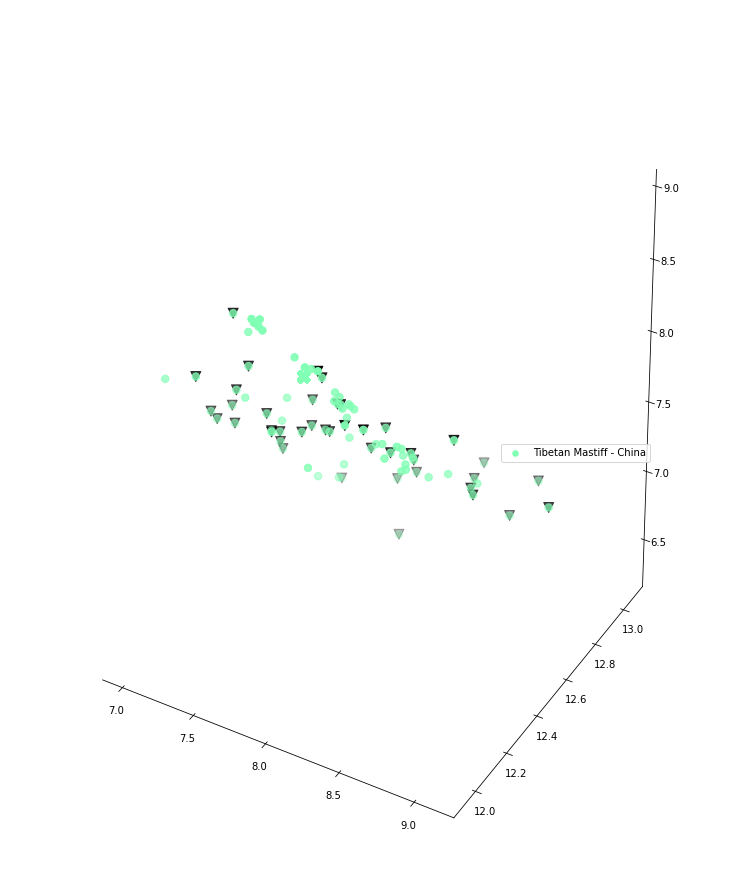

In [66]:
index = 80

path_prefix = osp.join(str(config['data.data_out']), config['geno_type'], \
                       ''.join(['sm_', config['data.sample_map']]),\
                    config['train.experiment_name'], str(config['train.experiment_id']))
    
y_vcf_labels = torch.tensor(val_labels[index,0:params.chmlen].reshape(1,params.n_win, params.aux_net_in)).float()
y_vcf_idx = torch.mode(y_vcf_labels,dim=2)[0]
y_vcf_idx = y_vcf_idx.detach().cpu().numpy()
y_pred_index = y_pred[index,:,:]
y_pred_index_np = y_pred_index.detach().cpu().numpy()
PCA_lbls_dict = load_path(osp.join(labels_path, 'Umap/labels.pkl'), en_pickle=True)
granular_pop_dict = load_path(osp.join(path_prefix, 'granular_pop.pkl'), en_pickle=True)

val_target_labels_idx = val_target_labels[index,:,:].detach().cpu().numpy().reshape(-1,params.dataset_dim)

# get pop_arr
pop_sample_map = pd.read_csv(osp.join(path_prefix, 'pop_sample_map.tsv'), sep="\t")
pop_arr = repeat_pop_arr(pop_sample_map)
        
# stack the target and pred 
y_vcf_idx = y_vcf_idx.reshape(-1,1)
y_pred_index_np = y_pred_index_np.reshape(-1, params.rnn_net_out)
print(y_vcf_idx.shape, y_pred_index_np.shape)

plot(y_vcf_idx, y_pred_index_np, PCA_lbls_dict, pop_arr,granular_pop_dict, val_target_labels_idx)

In [54]:
y_pred_index_np.shape

(81, 3)

In [64]:
rev_pop_dict

{0: 'Retriever',
 1: 'Husky',
 2: 'Hound',
 3: 'Terrier',
 4: 'Basenji',
 5: 'East',
 6: 'Greyhound',
 7: 'Tibetan_Mastiff'}

In [62]:
pop_arr[:,1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 20

In [46]:
y_labels = torch.tensor(val_labels[:,0:params.chmlen].reshape(-1,params.n_win, params.aux_net_in)).float()
y_vcf_labels = torch.mode(y_labels,dim=2)[0]
y_vcf_labels = y_vcf_labels.detach().cpu().numpy()
y_vcf_labels.shape
y_vcf_labels_flatten = y_vcf_labels.reshape(-1,1)
y_vcf_labels_flatten.shape

(201366, 1)

In [47]:
continent_map = {k:v for k,v in zip(pop_arr[:,1], pop_arr[:,2])}
# granular_pop_map = {k:v for k,v in zip(pop_arr[:,1], pop_arr[:,2])}
continent_labels = list(map(lambda x: continent_map[x.item()], y_vcf_labels_flatten.reshape(-1,1)))
# granular_pop_labels = list(map(lambda x: granular_pop_map[x.item()], y_vcf_labels_flatten.reshape(-1,1)))
superpop_dict = load_path(osp.join(path_prefix, 'superpop.pkl'), en_pickle=True)
rev_superpop_dict = {k:v for v,k in superpop_dict.items()}
# rev_pop_dict = {v:k for k,v in granular_pop_dict.items()}

In [48]:
y_pred_np = y_pred.detach().cpu().numpy()
embedding_vec = y_pred_np
gradient_cp_idx = np.where(abs(embedding_vec[:,:-1,:]-embedding_vec[:,1:,:])>0.3)
print(f'gradient_cp_idx:{gradient_cp_idx}')
mask_gradient = (abs(embedding_vec[:,:-1,:]-embedding_vec[:,1:,:])>0.3).astype(int)
mask_gradient = np.amax(mask_gradient, axis=2)
# add 0 at the end
mask_gradient = np.hstack((mask_gradient, np.zeros_like(mask_gradient[:,0].reshape(-1,1))))
mask_gradient.shape, mask_gradient[0,19], mask_gradient.sum(), (~mask_gradient).sum()

gradient_cp_idx:(array([   0,    0,    0, ..., 2485, 2485, 2485]), array([ 0,  0,  1, ..., 76, 78, 79]), array([0, 1, 0, ..., 2, 0, 1]))


((2486, 81), 0, 72814, -274180)

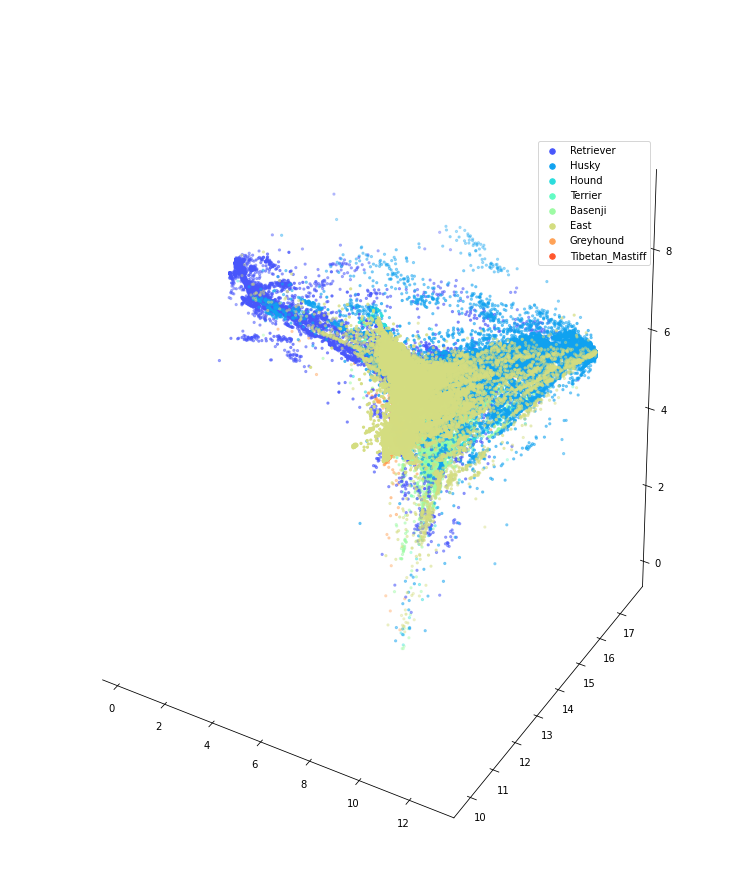

In [53]:
embedding_vec = y_pred_np
embedding_vec_flatten = embedding_vec[:,:,0:3].reshape(-1,3)

fig=plt.figure(figsize=(10,12))
plt.rcParams['savefig.transparent'] = True
ax= Axes3D(fig)
ax = fig.gca(projection='3d')

# colors1=['#0000ff','#008000', '#ff6dff', '#a3fecb', '#fffe58','#fc6500','#800080', '#ccccfe', '#4c4cfe', '#feccfe', '#000033', '#00fff2']
pop = list(superpop_dict.keys())
colors1 = sns.color_palette("rainbow", len(pop))

color_pop_dict = {k:v for k,v in zip(pop, colors1)}

j =0
rev_pop_dict = {v:k for k,v in superpop_dict.items()}



for i in np.arange(8):
    idx = np.nonzero(continent_labels==i)[0]
    ax.scatter(embedding_vec_flatten[idx,0], embedding_vec_flatten[idx,1], embedding_vec_flatten[idx,2], \
               color = colors1[j], s= 5, label = rev_superpop_dict[i])
#     text_idx = np.random.choice(idx,18)
#     for k in text_idx:
#         val_granular_pop=granular_pop_labels[k]
#         ax.text( embedding_vec_flatten[k,0], embedding_vec_flatten[k,1], embedding_vec_flatten[k,2], \
#                 s = rev_pop_dict[val_granular_pop])
    j +=1
    lgnd = ax.legend(bbox_to_anchor=(0.9,0.5+(i/20)))
    for l in lgnd.legendHandles:
        l._sizes = [30]

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#     ax.set_xlim(-2,2)
#     ax.set_ylim(-2,2)
#     ax.set_zlim(-2,2)
    

# ax.scatter(embedding_vec[gradient_cp_idx[0], gradient_cp_idx[1],0], \
#            embedding_vec[gradient_cp_idx[0],gradient_cp_idx[1], 1], \
#            embedding_vec[gradient_cp_idx[0],gradient_cp_idx[1],2], s=0.5,\
#            color='white', marker='v')
plt.show()